In [18]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format

In [10]:
# pip install terra-sdk==2.0.6

In [3]:
# from terra_sdk.client.lcd import LCDClient
# terra = LCDClient(chain_id="columbus-5", url="https://columbus-lcd.terra.dev")
# terra

In [104]:
# get toblin tax and other oracle parameters
terra.market.parameters()

{'base_pool': Dec('100000000000000'),
 'pool_recovery_period': 18,
 'min_stability_spread': Dec('1')}

In [ ]:
# import requests
# pr = requests.get('https://fcd.terra.dev/v1/market/price?denom=uusd&interval=1h').json()

In [ ]:
# pr

# Introduction


## Terra’s Mission 

Terra was created with the goal to power the innovation of money by building a price-stable cryptocurrency that can be used as a means of payment and store of value at a global scale. 

The Terra protocol acted as an algorithmic entity (the de-central bank) that is responsible for maintaining this peg. 


## How Terra worked under the hood ? 

To achieve this, it implemented the underlying Luna <> Terra coins mint / burn algorithm within the core protocol via the [market module](https://github.com/terra-money/classic-core/tree/main/x/market/spec). The underlying swaps were processed in International Monetary Fund’s  Special Drawing Rights (SDR), which is a basket of multiple currencies with the official SDR rate published by the IMF on a daily basis, allowing arbitragers, market makers, and Terra to closely align the exchange rate to the peg.

The mint / burn swap mechanism is implemented as a constant Product market-making algorithm and was aimed to be designed as a function of the parity between the off-chain liquidity of LUNA/UST and the on-chain liquidity parameters for the redemption of UST/LUNA. However, it failed to behave as expected triggering a “death spiral” bank run characteristic of traditional endogenous collateral models. You can refer to research article for Jump crypto covering the terra crash more in detail [here](https://jumpcrypto.com/the-depegging-of-ust/).




## Understanding Terra's Market Module

The **base market** starts out with two liquidity pools of equal sizes, 

- one representing Terra Stablecoins (all denominations), represented by `terra_pool` parameter
- ananother representing Luna, represented by `luna_pool` parameter


The **base market** is initialized by the parameter `BasePool` (denominated in [SDR](https://en.wikipedia.org/wiki/Special_drawing_rights) ), which defines the initial size of the Terra and Luna liquidity pools.

- The `base_pool` parameter is currently set to `100000000000000`, representing 100 Million SDR. 

Any market swap between Luna <> Terra stablecoins leads to a state transition of their `total_supply` parameter value based via the `mint` / `burn` functions, and this net transition is effectively also captured in the number variable `delta` which tracks net change in the sizes of the two pools, representing the deviation of the Terra pool from its base size in units µSDR.


### Swap Procedure

1. Market module receives `MsgSwap` message and performs basic validation checks

2. Calculate ask and spread using `k.ComputeSwap()`

3. Update TerraPoolDelta with `k.ApplySwapToPool()`

4. Transfer OfferCoin from account to module using `supply.SendCoinsFromAccountToModule()`

5. Burn offered coins, with `supply.BurnCoins()`.

6. Let `fee = spread * ask`, this is the `spread fee`.

7. Mint `ask - fee coins` of AskDenom with `supply.MintCoins()`. This implicitly applies the spread fee as the fee coins are burned.

8. Send newly minted coins to trader with `supply.SendCoinsFromModuleToAccount()`

9. Emit swap event to publicize swap and record spread fee


At the end of each block, the market module will attempt to "replenish" the pools by decreasing the magnitude of between the Terra and Luna pools. The rate at which the pools will be replenished toward equilibrium is set by the parameter `PoolRecoveryPeriod`, with lower periods meaning lower sensitivity to trades, meaning previous trades are more quickly forgotten and the market is able to offer more liquidity.

This mechanism ensures liquidity and acts as a sort of low-pass filter, allowing for the `spread fee` (which is a function of `TerraPoolDelta`) to drop back down when there is a change in demand, hence necessary change in supply which needs to be absorbed.

#### Seigniorage
For Luna swaps into Terra, the Luna that recaptured by the protocol is burned and is called seigniorage -- the value generated from issuing new Terra. At the end of the epoch, the total seigniorage for the epoch will be calculated and reintroduced into the economy as ballot rewards for the exchange rate oracle and to the community pool by the Treasury module, described more fully [here](https://github.com/terra-money/classic-core/blob/main/x/treasury/spec/README.md).


Jump crypto has been tracking the performance of the market module params and recommending updates via Governance as visible via the proposals here. Brief pointers from each proposal are mentioned here - 


1. [**Jan 21 → Proposal to update market module parameters by Jump crypto**](https://classic-agora.terra.money/t/terra-on-chain-liquidity-parameters/305). 

    This proposal was followed by another one by Do Kown [here](https://classic-agora.terra.money/t/tip-36-further-improvements-to-liquidity-parameters/372) proposing further increasing market module's parameters to `Basepool 7M → 13M SDT` `PoolRecoveryPeriod 200 → 130 blocks` which will roughly terra's stablecoin minting capacity. 



2. [**May 21 →  Proposal by Jump crypto to update market module parameters**](https://classic-agora.terra.money/t/liquidity-parameters-2/1175)

     Jump briefly discussed the oraclre attack possible to be executed on terra in-case on chain liquidity driven off the oracle price is larger than liquidity off chain. Short mention on how one possible solution to mitigate this can be splitting out the `TerraPoolDelta` parameter into `TerraPoolDeltaBid` and `TerraPoolDeltaAsk`. 
    Proposed parameter updates were the following - 

    - Increase BasePool size to 32,500,000 SDR
    - Reduce PoolRecoveryPeriod to 49 blocks
    - Split out TerraPoolDelta into TerraPoolDeltaBid and TerraPoolDeltaAsk.



3. [**Jan 29, 2022 →  Proposal by Jump crypto to update market module parameters**](https://classic-agora.terra.money/t/liquidity-parameters-3/3895)

    Proposed parameter updates were the following - 

    - Increase BasePool size to 50,000,000 SDR
    - Reduce PoolRecoveryPeriod to 36 blocks


5. [**Jan 29, 2022 →  Proposal by Jump crypto for BTC reserve pools**](https://classic-agora.terra.money/t/bitcoin-reserve-pool/5259/23) --> Most of the BTC accumulated for deploying the BTC reserve pool was sold during the May, 22 crash and is not relevent for our analysis. 


In [2]:
market_swap_txs_v1 =  pd.read_csv('./module_txs_data/v1/market_swap_txs.csv')
market_swap_send_txs_v1 =  pd.read_csv('./module_txs_data/v1/market_swap_send_txs.csv')

market_swap_txs_v2 =  pd.read_csv('./module_txs_data/v2/market_swap_txs.csv')
market_swap_send_txs_v2 =  pd.read_csv('./module_txs_data/v2/market_swap_send_txs.csv')

market_swap_txs_v3 =  pd.read_csv('./module_txs_data/v3/market_swap_txs.csv')
market_swap_send_txs_v3 =  pd.read_csv('./module_txs_data/v3/market_swap_send_txs.csv')

# market_swap_txs_v4 =  pd.read_csv('./module_txs_data/v4/market_swap_txs.csv')
# market_swap_send_txs_v4 =  pd.read_csv('./module_txs_data/v4/market_swap_send_txs.csv')

# market_swap_txs_v5 =  pd.read_csv('./module_txs_data/v5/market_swap_txs.csv')
# market_swap_send_txs_v5 =  pd.read_csv('./module_txs_data/v5/market_swap_send_txs.csv')

# market_swap_txs_v6 =  pd.read_csv('./module_txs_data/v6/market_swap_txs.csv')
# market_swap_send_txs_v6 =  pd.read_csv('./module_txs_data/v6/market_swap_send_txs.csv')

# market_swap_txs_v7 =  pd.read_csv('./module_txs_data/v7/market_swap_txs.csv')
# market_swap_send_txs_v7 =  pd.read_csv('./module_txs_data/v7/market_swap_send_txs.csv')

# market_swap_txs_v8 =  pd.read_csv('./module_txs_data/v8/market_swap_txs.csv')
# market_swap_send_txs_v8 =  pd.read_csv('./module_txs_data/v8/market_swap_send_txs.csv')

# market_swap_txs_v9 =  pd.read_csv('./module_txs_data/v8/market_swap_txs.csv')
# market_swap_send_txs_v9 =  pd.read_csv('./module_txs_data/v8/market_swap_send_txs.csv')


exchange_rate_vote_txs_v1 =  pd.read_csv('./module_txs_data/v1/exchange_rate_vote_txs.csv')
exchange_rate_vote_txs_v2 =  pd.read_csv('./module_txs_data/v2/exchange_rate_vote_txs.csv')
exchange_rate_vote_txs_v3 =  pd.read_csv('./module_txs_data/v3/exchange_rate_vote_txs.csv')
# exchange_rate_vote_txs_v4 =  pd.read_csv('./module_txs_data/v4/exchange_rate_vote_txs.csv')
# exchange_rate_vote_txs_v5 =  pd.read_csv('./module_txs_data/v5/exchange_rate_vote_txs.csv')
# exchange_rate_vote_txs_v6 =  pd.read_csv('./module_txs_data/v6/exchange_rate_vote_txs.csv')
# exchange_rate_vote_txs_v7 =  pd.read_csv('./module_txs_data/v7/exchange_rate_vote_txs.csv')
# exchange_rate_vote_txs_v8 =  pd.read_csv('./module_txs_data/v8/exchange_rate_vote_txs.csv')


astroport_ust_luna_txs_v1 =  pd.read_csv('./astroport_txs_data/astroport_swap_txs.csv')
# astroport_ust_luna_txs_v2 =  pd.read_csv('./astroport_txs_data/astroport_swap_txs1.csv')
# astroport_ust_luna_txs_v3 =  pd.read_csv('./astroport_txs_data/astroport_swap_txs2.csv')
# astroport_ust_luna_txs_v4 =  pd.read_csv('./astroport_txs_data/astroport_swap_txs3.csv')




In [3]:
# MERGE IN DFs :: MARKET SWAP TXs
market_swap_txs_DF = market_swap_txs_v1
market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v2], ignore_index=True)
market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v3], ignore_index=True)
# market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v4], ignore_index=True)
# market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v5], ignore_index=True)
# market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v6], ignore_index=True)
# market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v7], ignore_index=True)
# market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v8], ignore_index=True)
# market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_txs_v9], ignore_index=True)
market_swap_txs_DF.sort_values('BlockHeight', inplace=True)


# MERGE IN DFs :: MARKET SWAP SEND TXs
market_swap_send_txs_DF = market_swap_send_txs_v1
market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v2], ignore_index=True)
market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v3], ignore_index=True)
# market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v4], ignore_index=True)
# market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v5], ignore_index=True)
# market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v6], ignore_index=True)
# market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v7], ignore_index=True)
# market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v8], ignore_index=True)
# market_swap_send_txs_DF = pd.concat([market_swap_send_txs_DF, market_swap_send_txs_v9], ignore_index=True)
market_swap_send_txs_DF.sort_values('BlockHeight', inplace=True)


# MERGE IN DFs :: EXCHANGE RATE VOTE TXs
exchange_rate_vote_txs_DF = exchange_rate_vote_txs_v1
exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v2], ignore_index=True)
exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v3], ignore_index=True)
# exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v4], ignore_index=True)
# exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v5], ignore_index=True)
# exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v6], ignore_index=True)
# exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v7], ignore_index=True)
# exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v8], ignore_index=True)
# exchange_rate_vote_txs_DF = pd.concat([exchange_rate_vote_txs_DF, exchange_rate_vote_txs_v9], ignore_index=True)
exchange_rate_vote_txs_DF.sort_values('BlockHeight', inplace=True)




# MERGE IN DFs :: ASTROPORT SWAP TXs
astroport_ust_luna_txs_DF = astroport_ust_luna_txs_v1
# astroport_ust_luna_txs_DF = pd.concat([astroport_ust_luna_txs_DF, astroport_ust_luna_txs_v2], ignore_index=True)
# astroport_ust_luna_txs_DF = pd.concat([astroport_ust_luna_txs_DF, astroport_ust_luna_txs_v3], ignore_index=True)
# astroport_ust_luna_txs_DF = pd.concat([astroport_ust_luna_txs_DF, astroport_ust_luna_txs_v4], ignore_index=True)
astroport_ust_luna_txs_DF.sort_values('BlockHeight', inplace=True)


# SORT DFs
market_swap_txs_DF.drop_duplicates(inplace=True)
market_swap_txs_DF.sort_values('BlockHeight', inplace=True)

market_swap_send_txs_DF.drop_duplicates(inplace=True)
market_swap_send_txs_DF.sort_values('BlockHeight', inplace=True)

exchange_rate_vote_txs_DF.drop_duplicates(inplace=True)
exchange_rate_vote_txs_DF.sort_values('BlockHeight', inplace=True)

astroport_ust_luna_txs_DF.drop_duplicates(inplace=True)
astroport_ust_luna_txs_DF.sort_values('BlockHeight', inplace=True)

# Reset Indexes
market_swap_txs_DF = market_swap_txs_DF.reset_index()
market_swap_send_txs_DF = market_swap_send_txs_DF.reset_index()
exchange_rate_vote_txs_DF = exchange_rate_vote_txs_DF.reset_index()
astroport_ust_luna_txs_DF = astroport_ust_luna_txs_DF.reset_index()


### TERRA's MARKET MODULE -::- SWAP TXs

In [4]:
# market_swap_send_txs_v1.head(5)
# market_swap_txs_DF.head(5)

In [5]:
# MARKET SWAP TXs
# --- Remove & rename columns 
market_swap_txs_DF = market_swap_txs_DF.fillna(0)
market_swap_txs_DF.drop(['index','TxHash','Sender','burner','minter','recipient'],axis=1,inplace=True)
market_swap_txs_DF.rename(columns = {'ask_denom':'minted_denom', 'offer_coin':'burnt_denom'\
                                    , 'swap_coin':'swap_amount', 'swap_fee':'swap_fee_amount'}, inplace = True)
market_swap_txs_DF["tokens_burnt"] = market_swap_txs_DF["burnt_denom"]


# MARKET SWAP SEND TXs
# --- Remove & rename columns 
market_swap_send_txs_DF = market_swap_send_txs_DF.fillna(0)
market_swap_send_txs_DF.drop(['TxHash','Sender','burner','minter','recipient'],axis=1,inplace=True)
market_swap_send_txs_DF.rename(columns = {'ask_denom':'minted_denom', 'offer_coin':'burnt_denom'\
                                    , 'swap_coin':'swap_amount', 'swap_fee':'swap_fee_amount'}, inplace = True)
market_swap_send_txs_DF["tokens_burnt"] = market_swap_send_txs_DF["burnt_denom"]


In [6]:
def market_swap_extract_amount_(x):
    try:
        if x[len(x) - 5:] == "uluna":
            return int(x[: len(x) - 5])
        else:
            return int(x[: len(x) - 4])
    except:
        return x
    
    
def market_swap_extract_denom_(x):
    try:
        if x[len(x) - 5:] == "uluna":
            return "uluna"
        else:
            return x[len(x) - 4:]
    except:
        return x


In [7]:
# MARKET SWAP TXs -::- Data Cleanup
market_swap_txs_DF["tokens_minted"] = market_swap_txs_DF.apply(lambda x: market_swap_extract_amount_(x["tokens_minted"]), axis=1 )
market_swap_txs_DF["tokens_burnt"] = market_swap_txs_DF.apply(lambda x: market_swap_extract_amount_(x["tokens_burnt"]), axis=1 )
market_swap_txs_DF["burnt_denom"] = market_swap_txs_DF.apply(lambda x: market_swap_extract_denom_(x["burnt_denom"]), axis=1 )
market_swap_txs_DF["swap_amount"] = market_swap_txs_DF.apply(lambda x: market_swap_extract_amount_(x["swap_amount"]), axis=1 )
market_swap_txs_DF["swap_fee_amount"] = market_swap_txs_DF.apply(lambda x: market_swap_extract_amount_(x["swap_fee_amount"]), axis=1 )
market_swap_txs_DF = market_swap_txs_DF[['BlockHeight','trader','burnt_denom','tokens_burnt','minted_denom','tokens_minted','swap_amount','swap_fee_amount']]

# MARKET SWAP SEND TXs -::- Data Cleanup
market_swap_send_txs_DF["tokens_minted"] = market_swap_send_txs_DF.apply(lambda x: market_swap_extract_amount_(x["tokens_minted"]), axis=1 )
market_swap_send_txs_DF["tokens_burnt"] = market_swap_send_txs_DF.apply(lambda x: market_swap_extract_amount_(x["tokens_burnt"]), axis=1 )
market_swap_send_txs_DF["burnt_denom"] = market_swap_send_txs_DF.apply(lambda x: market_swap_extract_denom_(x["burnt_denom"]), axis=1 )
market_swap_send_txs_DF["swap_amount"] = market_swap_send_txs_DF.apply(lambda x: market_swap_extract_amount_(x["swap_amount"]), axis=1 )
market_swap_send_txs_DF["swap_fee_amount"] = market_swap_send_txs_DF.apply(lambda x: market_swap_extract_amount_(x["swap_fee_amount"]), axis=1 )
market_swap_send_txs_DF = market_swap_send_txs_DF[['BlockHeight','trader','burnt_denom','tokens_burnt','minted_denom','tokens_minted','swap_amount','swap_fee_amount']]

# Concatenate the DFs
market_swap_txs_DF = pd.concat([market_swap_txs_DF, market_swap_send_txs_DF], ignore_index=True)
market_swap_txs_DF.sort_values('BlockHeight', inplace=True)


In [8]:

# MARKET SWAP TXs -::- Adjust Decimals
market_swap_txs_DF["tokens_burnt"] = market_swap_txs_DF.apply(lambda x: int(x["tokens_burnt"])/10**6, axis=1 )
market_swap_txs_DF["tokens_minted"] = market_swap_txs_DF.apply(lambda x: int(x["tokens_minted"])/10**6, axis=1 )
market_swap_txs_DF["swap_amount"] = market_swap_txs_DF.apply(lambda x: int(x["swap_amount"])/10**6, axis=1 )
market_swap_txs_DF["swap_fee_amount"] = market_swap_txs_DF.apply(lambda x: int(x["swap_fee_amount"])/10**6, axis=1 )


In [9]:
market_swap_txs_DF.tail(14)

,BlockHeight,trader,burnt_denom,tokens_burnt,minted_denom,tokens_minted,swap_amount,swap_fee_amount
344867,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,uidr,0.292,uusd,0.000,0.000,0.000
344866,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,ujpy,0.004,uusd,0.000,0.000,0.000
344865,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,umnt,175.050,uusd,0.057,0.056,0.001
344864,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,umyr,0.000,uusd,0.000,0.000,0.000
344863,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,unok,0.000,uusd,0.000,0.000,0.000
344862,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,uphp,0.005,uusd,0.000,0.000,0.000
344868,7608010,terra1js5dzktwsyqspwytkystka6upmpau3hnc0k3s5,uchf,0.000,uusd,0.000,0.000,0.000
344878,7608018,terra1st6uf6u3yfas9zydcx0zktrvad9qdzv8dyztex,uusd,1.000,ukrw,"1,282.398","1,277.910",4.488
344879,7608036,terra198cgx6xmxta2l7cflz954ynxu234pcgt2u6vam,ukrw,"27,441.099",uusd,21.398,21.323,0.075
344880,7608037,terra1sd35vlsqacxz4knmvq2mtcm5azrss2flg9v0d4,uusd,"1,503.000",uaud,"2,181.517","2,173.882",7.635


### Aggregate total mint / burn amounts per block

In [10]:
# AGGREGATE SWAP VALUES FOR EACH BLOCK :::: market_swap_txs_DF
def aggregate_swaps_per_block(df, start_height, end_height):
    response_DF = pd.DataFrame(columns=["BlockHeight","uluna::minted","uluna::burnt","uluna::swap_amount","uluna::swap_fee_amount",\
                                        "uusd::minted","uusd::burnt","uusd::swap_amount","uusd::swap_fee_amount",\
                                        "ukrw::minted","ukrw::burnt","ukrw::swap_amount","ukrw::swap_fee_amount",\
                                        "usdr::minted","usdr::burnt","usdr::swap_amount","usdr::swap_fee_amount",\
                                        "ucny::minted","ucny::burnt","ucny::swap_amount","ucny::swap_fee_amount",\
                                        "ujpy::minted","ujpy::burnt","ujpy::swap_amount","ujpy::swap_fee_amount",\
                                        "ugbp::minted","ugbp::burnt","ugbp::swap_amount","ugbp::swap_fee_amount",\
                                        "umnt::minted","umnt::burnt","umnt::swap_amount","umnt::swap_fee_amount",\
                                        "ucad::minted","ucad::burnt","ucad::swap_amount","ucad::swap_fee_amount",\
                                        "uaud::minted","uaud::burnt","uaud::swap_amount","uaud::swap_fee_amount",\
                                        "ueur::minted","ueur::burnt","ueur::swap_amount","ueur::swap_fee_amount",\
                                        "uchf::minted","uchf::burnt","uchf::swap_amount","uchf::swap_fee_amount",\
                                        "utwd::minted","utwd::burnt","utwd::swap_amount","utwd::swap_fee_amount",\
                                        "uhkd::minted","uhkd::burnt","uhkd::swap_amount","uhkd::swap_fee_amount",\
                                        "usgd::minted","usgd::burnt","usgd::swap_amount","usgd::swap_fee_amount",\
                                        "usek::minted","usek::burnt","usek::swap_amount","usek::swap_fee_amount",\
                                        "udkk::minted","udkk::burnt","udkk::swap_amount","udkk::swap_fee_amount",\
                                        "uidr::minted","uidr::burnt","uidr::swap_amount","uidr::swap_fee_amount",\
                                        "uthb::minted","uthb::burnt","uthb::swap_amount","uthb::swap_fee_amount",\
                                        "uphp::minted","uphp::burnt","uphp::swap_amount","uphp::swap_fee_amount",\
                                        "unok::minted","unok::burnt","unok::swap_amount","unok::swap_fee_amount",\
                                        "uinr::minted","uinr::burnt","uinr::swap_amount","uinr::swap_fee_amount",\
                                        "umyr::minted","umyr::burnt","umyr::swap_amount","umyr::swap_fee_amount"
                                       ])
    cur_height = start_height
        
    # Loop all blocks and compute aggregated values for each block
    while (cur_height <=end_height):
        cur_DF = df.loc[ df["BlockHeight"] == cur_height ]
        tokens = {"uluna": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "uusd": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "ukrw": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "usdr": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "ucny": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "ujpy": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "ugbp": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "umnt": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "ucad": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "uaud": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "ueur": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "uchf": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "utwd": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "uhkd": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, }, 
                  "usgd": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "usek": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "udkk": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "uidr": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "uthb": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "uphp": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "unok": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "uinr": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  "umyr": {"minted":0,"burnt":0,"swap_amount":0,"swap_fee_amount":0, },
                  
                 }
        # Loop over all txs for each block
        for tx_row in cur_DF.to_dict(orient='records'): # cur_DF.values.tolist():
            try:
                tokens[ tx_row["burnt_denom"] ]["burnt"] += float(tx_row["tokens_burnt"])
                tokens[ tx_row["minted_denom"] ]["minted"] += float(tx_row["tokens_minted"])
                tokens[ tx_row["minted_denom"] ]["swap_amount"] += float(tx_row["swap_amount"])
                tokens[ tx_row["minted_denom"] ]["swap_fee_amount"] += float(tx_row["swap_fee_amount"])
            except NameError:
                print(NameError)
        # Add row to the response DF
        response_DF.loc[len(response_DF.index)] = [cur_height,tokens["uluna"]["minted"],tokens["uluna"]["burnt"]
                                                   ,tokens["uluna"]["swap_amount"],tokens["uluna"]["swap_fee_amount"]
                                                   ,tokens["uusd"]["minted"],tokens["uusd"]["burnt"]
                                                   ,tokens["uusd"]["swap_amount"],tokens["uusd"]["swap_fee_amount"]
                                                   ,tokens["ukrw"]["minted"],tokens["ukrw"]["burnt"]
                                                   ,tokens["ukrw"]["swap_amount"],tokens["ukrw"]["swap_fee_amount"]
                                                   ,tokens["usdr"]["minted"],tokens["usdr"]["burnt"]
                                                   ,tokens["usdr"]["swap_amount"],tokens["usdr"]["swap_fee_amount"]
                                                   ,tokens["ucny"]["minted"],tokens["ucny"]["burnt"]
                                                   ,tokens["ucny"]["swap_amount"],tokens["ucny"]["swap_fee_amount"]
                                                   ,tokens["ujpy"]["minted"],tokens["ujpy"]["burnt"]
                                                   ,tokens["ujpy"]["swap_amount"],tokens["ujpy"]["swap_fee_amount"]
                                                   ,tokens["ugbp"]["minted"],tokens["ugbp"]["burnt"]
                                                   ,tokens["ugbp"]["swap_amount"],tokens["ugbp"]["swap_fee_amount"]
                                                   ,tokens["umnt"]["minted"],tokens["umnt"]["burnt"]
                                                   ,tokens["umnt"]["swap_amount"],tokens["umnt"]["swap_fee_amount"]
                                                    ,tokens["ucad"]["minted"],tokens["ucad"]["burnt"]
                                                   ,tokens["ucad"]["swap_amount"],tokens["ucad"]["swap_fee_amount"]
                                                   ,tokens["uaud"]["minted"],tokens["uaud"]["burnt"]
                                                   ,tokens["uaud"]["swap_amount"],tokens["uaud"]["swap_fee_amount"]
                                                   ,tokens["ueur"]["minted"],tokens["ueur"]["burnt"]
                                                   ,tokens["ueur"]["swap_amount"],tokens["ueur"]["swap_fee_amount"]
                                                   ,tokens["uchf"]["minted"],tokens["uchf"]["burnt"]
                                                   ,tokens["uchf"]["swap_amount"],tokens["uchf"]["swap_fee_amount"]
                                                   ,tokens["utwd"]["minted"],tokens["utwd"]["burnt"]
                                                   ,tokens["utwd"]["swap_amount"],tokens["utwd"]["swap_fee_amount"]
                                                   ,tokens["uhkd"]["minted"],tokens["uhkd"]["burnt"]
                                                   ,tokens["uhkd"]["swap_amount"],tokens["uhkd"]["swap_fee_amount"]
                                                   ,tokens["usgd"]["minted"],tokens["usgd"]["burnt"]
                                                   ,tokens["usgd"]["swap_amount"],tokens["usgd"]["swap_fee_amount"]
                                                   ,tokens["usek"]["minted"],tokens["usek"]["burnt"]
                                                   ,tokens["usek"]["swap_amount"],tokens["usek"]["swap_fee_amount"]
                                                   ,tokens["udkk"]["minted"],tokens["udkk"]["burnt"]
                                                   ,tokens["udkk"]["swap_amount"],tokens["udkk"]["swap_fee_amount"]
                                                   ,tokens["uidr"]["minted"],tokens["uidr"]["burnt"]
                                                   ,tokens["uidr"]["swap_amount"],tokens["uidr"]["swap_fee_amount"]
                                                   ,tokens["uthb"]["minted"],tokens["uthb"]["burnt"]
                                                   ,tokens["uthb"]["swap_amount"],tokens["uthb"]["swap_fee_amount"]
                                                   ,tokens["uphp"]["minted"],tokens["uphp"]["burnt"]
                                                   ,tokens["uphp"]["swap_amount"],tokens["uphp"]["swap_fee_amount"]
                                                   ,tokens["unok"]["minted"],tokens["unok"]["burnt"]
                                                   ,tokens["unok"]["swap_amount"],tokens["unok"]["swap_fee_amount"]
                                                   ,tokens["uinr"]["minted"],tokens["uinr"]["burnt"]
                                                   ,tokens["uinr"]["swap_amount"],tokens["uinr"]["swap_fee_amount"]
                                                   ,tokens["umyr"]["minted"],tokens["umyr"]["burnt"]
                                                   ,tokens["umyr"]["swap_amount"],tokens["umyr"]["swap_fee_amount"]
                                                  ]
        cur_height +=1
    
    return response_DF

In [11]:
start_block = int(market_swap_txs_DF.loc[0]["BlockHeight"])
end_block = int(market_swap_txs_DF.loc[len(market_swap_txs_DF.index) - 1]["BlockHeight"])


aggregated_market_swap_txs_DF = aggregate_swaps_per_block(market_swap_txs_DF, start_block, end_block)
aggregated_market_swap_txs_DF["BlockHeight"] = aggregated_market_swap_txs_DF.apply(lambda x: int(x["BlockHeight"]), axis=1 )




##### Here we remove all terra stable coins other than UST. Our analysis & simulations only account for UST <> LUNA swaps

In [12]:
# aggregated_market_swap_txs_DF.head(3)

In [13]:
# aggregated_market_swap_txs_DF_ukrw = aggregated_market_swap_txs_DF[["BlockHeight", "ukrw::minted", "ukrw::burnt","ukrw::swap_amount", "ukrw::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_usdr = aggregated_market_swap_txs_DF[["BlockHeight", "usdr::minted", "usdr::burnt","usdr::swap_amount", "usdr::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_ucny = aggregated_market_swap_txs_DF[["BlockHeight", "ucny::minted", "ucny::burnt","ucny::swap_amount", "ucny::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_ujpy = aggregated_market_swap_txs_DF[["BlockHeight", "ujpy::minted", "ujpy::burnt","ujpy::swap_amount", "ujpy::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_ugbp = aggregated_market_swap_txs_DF[["BlockHeight", "ugbp::minted", "ugbp::burnt","ugbp::swap_amount", "ugbp::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_umnt = aggregated_market_swap_txs_DF[["BlockHeight", "umnt::minted", "umnt::burnt","umnt::swap_amount", "umnt::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_ucad = aggregated_market_swap_txs_DF[["BlockHeight", "ucad::minted", "ucad::burnt","ucad::swap_amount", "ucad::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uaud = aggregated_market_swap_txs_DF[["BlockHeight", "uaud::minted", "uaud::burnt","uaud::swap_amount", "uaud::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_ueur = aggregated_market_swap_txs_DF[["BlockHeight", "ueur::minted", "ueur::burnt","ueur::swap_amount", "ueur::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uchf = aggregated_market_swap_txs_DF[["BlockHeight", "uchf::minted", "uchf::burnt","uchf::swap_amount", "uchf::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_utwd = aggregated_market_swap_txs_DF[["BlockHeight", "utwd::minted", "utwd::burnt","utwd::swap_amount", "utwd::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uhkd = aggregated_market_swap_txs_DF[["BlockHeight", "uhkd::minted", "uhkd::burnt","uhkd::swap_amount", "uhkd::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_usgd = aggregated_market_swap_txs_DF[["BlockHeight", "usgd::minted", "usgd::burnt","usgd::swap_amount", "usgd::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_usek = aggregated_market_swap_txs_DF[["BlockHeight", "usek::minted", "usek::burnt","usek::swap_amount", "usek::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_udkk = aggregated_market_swap_txs_DF[["BlockHeight", "udkk::minted", "udkk::burnt","udkk::swap_amount", "udkk::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uidr = aggregated_market_swap_txs_DF[["BlockHeight", "uidr::minted", "uidr::burnt","uidr::swap_amount", "uidr::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uthb = aggregated_market_swap_txs_DF[["BlockHeight", "uthb::minted", "uthb::burnt","uthb::swap_amount", "uthb::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uphp = aggregated_market_swap_txs_DF[["BlockHeight", "uphp::minted", "uphp::burnt","uphp::swap_amount", "uphp::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_unok = aggregated_market_swap_txs_DF[["BlockHeight", "unok::minted", "unok::burnt","unok::swap_amount", "unok::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_uinr = aggregated_market_swap_txs_DF[["BlockHeight", "uinr::minted", "uinr::burnt","uinr::swap_amount", "uinr::swap_fee_amount"]]
# aggregated_market_swap_txs_DF_umyr = aggregated_market_swap_txs_DF[["BlockHeight", "umyr::minted", "umyr::burnt","umyr::swap_amount", "umyr::swap_fee_amount"]]


In [14]:
# Plot burnt charts 
# plt.plot(aggregated_market_swap_txs_DF_ukrw["BlockHeight"],aggregated_market_swap_txs_DF_ukrw["ukrw::burnt"])
# plt.title('Burnt graph')
# plt.xlabel('Block Height')
# plt.ylabel('Tokens burnt')
# plt.show()

In [15]:
aggregated_market_swap_txs_DF = aggregated_market_swap_txs_DF[["BlockHeight", "uusd::minted", "uusd::burnt","uusd::swap_amount", "uusd::swap_fee_amount","uluna::minted", "uluna::burnt","uluna::swap_amount", "uluna::swap_fee_amount"]]






In [16]:
aggregated_market_swap_txs_DF.head(3)

,BlockHeight,uusd::minted,uusd::burnt,uusd::swap_amount,uusd::swap_fee_amount,uluna::minted,uluna::burnt,uluna::swap_amount,uluna::swap_fee_amount
0,7489160,748.411,0.000,744.669,3.742,0.000,8.829,0.000,0.000
1,7489161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,7489162,622.107,0.000,618.996,3.111,0.000,7.339,0.000,0.000


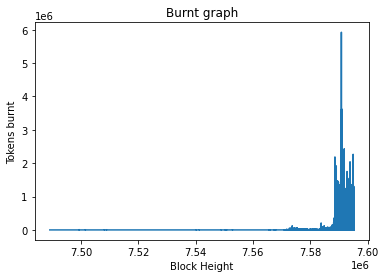

In [17]:
# Plot burnt charts 
plt.plot(aggregated_market_swap_txs_DF["BlockHeight"],aggregated_market_swap_txs_DF["uluna::minted"])
plt.title('Burnt graph')
plt.xlabel('Block Height')
plt.ylabel('Tokens burnt')
plt.show()

### Astroport :: Gives LUNA <> UST Trading price 

In [18]:
# ASTROPORT :: SWAPS DATA CLEAN-UP

def calc_price_luna_ust(x):
    if x["offer_asset"] == "uluna" and int(x["return_amount"]) != 0 :
        return int(x["offer_amount"]) / int(x["return_amount"] )
    elif int(x["offer_amount"]) != 0 :
        return int(x["return_amount"]) / int(x["offer_amount"] )
    else:
        return 0

    
def calc_price_ust_luna(x):
    if x["offer_asset"] == "uusd" and int(x["return_amount"]) != 0 :
        return int(x["offer_amount"]) / int(x["return_amount"] )
    elif int(x["offer_amount"]) != 0 :
        return int(x["return_amount"]) / int(x["offer_amount"] )
    else:
        return 0
    

# astroport_ust_luna_txs_DF.drop(['TxHash','UserAddress','tax_amount','commission_amount','maker_fee_amount'],axis=1,inplace=True)



In [19]:
# ASTROPORT SWAP TXs
# --- Remove & rename columns 
astroport_ust_luna_txs_DF = astroport_ust_luna_txs_DF.fillna(0)
astroport_ust_luna_txs_DF.drop(['index','TxHash','UserAddress','tax_amount','commission_amount','maker_fee_amount'],axis=1,inplace=True)
astroport_ust_luna_txs_DF["Price (luna/ust)"] = astroport_ust_luna_txs_DF.apply(lambda x: calc_price_luna_ust(x), axis=1)
astroport_ust_luna_txs_DF["Price (ust/luna)"] = astroport_ust_luna_txs_DF.apply(lambda x: calc_price_ust_luna(x), axis=1)


In [20]:
astroport_ust_luna_txs_DF["offer_amount"] = astroport_ust_luna_txs_DF.apply(lambda x: int(x["offer_amount"])/10**6, axis=1)
astroport_ust_luna_txs_DF["return_amount"] = astroport_ust_luna_txs_DF.apply(lambda x: int(x["return_amount"])/10**6, axis=1)
astroport_ust_luna_txs_DF["spread_amount"] = astroport_ust_luna_txs_DF.apply(lambda x: int(x["spread_amount"])/10**6, axis=1)


In [21]:
astroport_ust_luna_txs_DF.head(5)

,BlockHeight,offer_asset,offer_amount,ask_asset,return_amount,spread_amount,belief_price,Price (luna/ust),Price (ust/luna)
0,7584273,uluna,"1,000.000",uusd,"18,863.524",6.932,0.053,0.053,18.864
1,7584274,uusd,"2,050.000",uluna,108.138,0.004,18.996,0.053,18.957
2,7584274,uusd,"2,000.000",uluna,105.424,0.004,18.996,0.053,18.971
3,7584275,uluna,1.000,uusd,18.834,0.000,0.053,0.053,18.834
4,7584276,uluna,1.145,uusd,21.454,0.000,0.053,0.053,18.741


In [22]:
# # Plot charts 
# plt.plot(astroport_ust_luna_txs_DF["BlockHeight"],astroport_ust_luna_txs_DF["Price (ust/luna)"])
# plt.title('')
# plt.xlabel('Block Height')
# plt.ylabel('Price (ust/luna)')
# plt.show()

### Oracle Feed :: Oracle prices as provided by Validators

In [23]:
# exchange_rate_vote_txs_DF.head(4)

In [24]:
# get exchange rate for each a currency(denom)
def index_exchange_rates(column,denom):
    words = column.split(",")
    for word in words:
        val = word[:len(word)-4]
        label = word[len(word)-4:]
        if label == denom:
            return val
    return 0

# get list of currences
def get_labels(column):
    words = column.split(",")
    labels = []
    for word in words:
        val = word[:len(word)-4]
        label = word[len(word)-4:]
        labels.append(label)
    return labels



In [25]:
# list of all currencies
labels = get_labels( exchange_rate_vote_txs_DF.loc[0]["exchange_rates"]  )

# Index Exchange rate for all currencies
for label in labels:
    exchange_rate_vote_txs_DF[label] = exchange_rate_vote_txs_DF.apply(lambda x: index_exchange_rates(x["exchange_rates"],label), axis=1)

exchange_rate_vote_txs_DF.drop(['index','TxHash','salt','feeder','validator','exchange_rates'],axis=1,inplace=True)


In [26]:
exchange_rate_vote_txs_DF = exchange_rate_vote_txs_DF[["BlockHeight","ukrw","usdr","uusd"]]

In [27]:
exchange_rate_vote_txs_DF.head(4)

,BlockHeight,ukrw,usdr,uusd
0,7536855,98033.889646656772357504,56.4691564063960821,77.239044402371346717
1,7536855,98181.668561423364176924,57.423985473298196688,77.239044402371346717
2,7536855,98181.668561423364176924,57.423985473298196688,77.239044402371346717
3,7536855,98024.172200684480400633,56.463558995353249203,77.231388210786612433


In [28]:
# AGGREGATE SWAP VALUES FOR EACH BLOCK :::: market_swap_txs_DF
def aggregate_exchange_rates_per_block(df, start_height, end_height):
    response_DF = pd.DataFrame(columns=["BlockHeight","ukrw::mean","usdr::mean","uusd::mean"])
    cur_height = start_height
        
    # Loop all blocks and compute aggregated values for each block
    while (cur_height <=end_height):
        cur_DF = df.loc[ df["BlockHeight"] == cur_height ]
        prices = {"ukrw": {"price_total":0,"index":0}, 
                  "usdr": {"price_total":0,"index":0}, 
                  "uusd": {"price_total":0,"index":0}
                 }
        # Loop over all txs for each block
        for tx_row in cur_DF.to_dict(orient='records'): # cur_DF.values.tolist():
#             print(tx_row)
            try:
                if float(tx_row["ukrw"]) > 0:
                    prices["ukrw"]["price_total"] = prices["ukrw"]["price_total"] + float(tx_row["ukrw"])
#                     print(prices["ukrw"]["price_total"])
                    prices["ukrw"]["index"] = prices["ukrw"]["index"] + 1
                if float(tx_row["usdr"]) > 0:
                    prices["usdr"]["price_total"] = prices["usdr"]["price_total"] + float(tx_row["usdr"])
#                     print(prices["usdr"]["price_total"])
                    prices["usdr"]["index"] = prices["usdr"]["index"] + 1
                if float(tx_row["uusd"]) > 0:
                    prices["uusd"]["price_total"] = prices["uusd"]["price_total"] + float(tx_row["uusd"])
#                     print(prices["uusd"]["price_total"])
                    prices["uusd"]["index"] = prices["uusd"]["index"] + 1
            except NameError:
                print(NameError)
        
        mean_ukrw_price = 0
        mean_usdr_price = 0
        mean_uusd_price = 0
        # calculate mean prices
        if prices["ukrw"]["index"] > 0:
            mean_ukrw_price = prices["ukrw"]["price_total"] / prices["ukrw"]["index"]
        if prices["usdr"]["index"] > 0:        
            mean_usdr_price = prices["usdr"]["price_total"] / prices["usdr"]["index"]
        if prices["uusd"]["index"] > 0:        
            mean_uusd_price = prices["uusd"]["price_total"] / prices["uusd"]["index"]
            
        # Add row to the response DF
        response_DF.loc[len(response_DF.index)] = [int(cur_height),mean_ukrw_price, mean_usdr_price,mean_uusd_price]
        cur_height +=1
    
    return response_DF

In [29]:
aggregated_exchange_rate_vote_txs_DF = aggregate_exchange_rates_per_block(exchange_rate_vote_txs_DF, 7589925, 7608055)




In [30]:
aggregated_exchange_rate_vote_txs_DF["BlockHeight"] = aggregated_exchange_rate_vote_txs_DF.apply(lambda x: int(x["BlockHeight"]), axis =1 )



In [31]:
# aggregated_exchange_rate_vote_txs_DF.tail(3)

In [32]:
# exchange_rate_vote_txs_DF.tail(153)

In [33]:
len(aggregated_exchange_rate_vote_txs_DF.index)

18131

In [34]:
# Store aggregated DFs

In [35]:
aggregated_exchange_rate_vote_txs_DF.to_csv("./cleaned_data/aggregated_exchange_rate_vote_txs_DF.csv") 

In [36]:
astroport_ust_luna_txs_DF.to_csv("./cleaned_data/astroport_ust_luna_txs_DF.csv") 

In [37]:
aggregated_market_swap_txs_DF.to_csv("./cleaned_data/aggregated_market_swap_txs_DF.csv") 

In [38]:
market_swap_txs_DF.to_csv("./cleaned_data/market_swap_txs_DF.csv") 

# SIMULATE MARKET MODULE's STATE TRANSITION CHANGES DURING THE CRASH

In [105]:
# Get DataFrames from pre-processed .csv files

## Oracle prices
aggregated_exchange_rate_vote_txs_DF = pd.read_csv("./cleaned_data/aggregated_exchange_rate_vote_txs_DF.csv") 

## Astroport Transactions
astroport_ust_luna_txs_DF = pd.read_csv("./cleaned_data/astroport_ust_luna_txs_DF.csv") 

## Market Swaps via Module :: Aggregated Trading Volumes / Supply contraction / expansion dynamics
aggregated_market_swap_txs_DF = pd.read_csv("./cleaned_data/aggregated_market_swap_txs_DF.csv") 

## All txs which happened via Market Module 
market_swap_txs_DF = pd.read_csv("./cleaned_data/market_swap_txs_DF.csv") 

# Remove index column
aggregated_exchange_rate_vote_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)
astroport_ust_luna_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)
aggregated_market_swap_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)
market_swap_txs_DF.drop(['Unnamed: 0'],axis=1,inplace=True)

In [138]:
# https://classic-agora.terra.money/t/liquidity-parameters-3/3895


def simulate_terra_classic(terra_classic_instance, market_swap_txs_DF, exchange_rate_txs_DF, start_height, end_height):
    simulation_metrics_DF = pd.DataFrame(columns=['BlockHeight','burnt_denom', 'tokens_burnt', 'minted_denom',
       'tokens_minted', 'swap_amount', 'swap_fee_amount', 'lunaPool', 'delta','ukrw_oracle_price','usdr_oracle_price'\
                                                 ,'uusd_oracle_price'])
    
    cur_height = start_height

    prices = {"ukrw": {"price_total":0,"index":0}, 
              "usdr": {"price_total":0,"index":0}, 
              "uusd": {"price_total":0,"index":0}
             }    
    
    
    # Process all blocks 
    while(cur_height <= end_height):
        # Get all market swap txs to be processed for the current block
        cur_swap_txs_DF = market_swap_txs_DF.loc[ market_swap_txs_DF["BlockHeight"] == cur_height ]
        
        # Loop over all txs for each block
        for tx_row in cur_swap_txs_DF.to_dict(orient='records'):
            # Process swap tx
            if (tx_row["burnt_denom"] == "uusd" or tx_row["burnt_denom"] == "uluna") and (tx_row["minted_denom"] == "uusd" or tx_row["minted_denom"] == "uluna"):
                swapCoin, swapFee, err = terra_classic_instance.Swap("trader", {"denom":tx_row["burnt_denom"], "amount":float(tx_row["tokens_burnt"]) }, tx_row["minted_denom"])
                print("\n")
                if err != None:
                    print(err)
                else:
                    lunaPool = terra_classic_instance.get_LunaPool_fromTerraPool()
                    delta = terra_classic_instance.GetTerraPoolDelta()
                    ukrw_oracle_price = terra_classic_instance.OracleKeeper.GetLunaExchangeRate("ukrw")
                    usdr_oracle_price = terra_classic_instance.OracleKeeper.GetLunaExchangeRate("usdr")
                    uusd_oracle_price = terra_classic_instance.OracleKeeper.GetLunaExchangeRate("uusd")
                    print(f"usdr_oracle_price = {usdr_oracle_price} || uusd_oracle_price = {uusd_oracle_price}")
                    
                    # store metrics
                    simulation_metrics_DF.loc[len(simulation_metrics_DF.index)] = [cur_height, tx_row["burnt_denom"],\
                                                tx_row["tokens_burnt"], tx_row["minted_denom"], float(swapCoin["amount"]) + float(swapFee["amount"]),\
                                                swapCoin["amount"], swapFee["amount"], lunaPool, delta, ukrw_oracle_price,\
                                                usdr_oracle_price, uusd_oracle_price ]
                    
        
        # Replensih Market module's pool after each block
        terra_classic_instance.TerraMarketModuleEndBlock()
        
        # Increment block number
        cur_height = cur_height + 1
        
        # Update Oracle prices if needed
        cur_price_DF = exchange_rate_txs_DF.loc[ exchange_rate_txs_DF["BlockHeight"] == cur_height ]        
        if not cur_price_DF.empty:
            for tx_row in cur_price_DF.to_dict(orient='records'):
#                 print(tx_row)
                if float(tx_row["ukrw::mean"]) > 0:
                    prices["ukrw"]["price_total"] = prices["ukrw"]["price_total"] + float(tx_row["ukrw::mean"])
                    prices["ukrw"]["index"] = prices["ukrw"]["index"] + 1
                if float(tx_row["usdr::mean"]) > 0:
                    prices["usdr"]["price_total"] = prices["usdr"]["price_total"] + float(tx_row["usdr::mean"])
                    prices["usdr"]["index"] = prices["usdr"]["index"] + 1
                if float(tx_row["uusd::mean"]) > 0:
                    prices["uusd"]["price_total"] = prices["uusd"]["price_total"] + float(tx_row["uusd::mean"])
                    prices["uusd"]["index"] = prices["uusd"]["index"] + 1

                    
        # Update oracle prices every 5 blocks
        if cur_height%5 == 0:
            if prices["ukrw"]["index"] > 0:
                mean_ukrw_price = prices["ukrw"]["price_total"] / prices["ukrw"]["index"]
                terra_classic_instance.OracleKeeper.SetLunaExchangeRate("ukrw", mean_ukrw_price )
                prices["ukrw"]["price_total"] = 0
                prices["ukrw"]["index"] = 0
            if prices["usdr"]["index"] > 0:        
                mean_usdr_price = prices["usdr"]["price_total"] / prices["usdr"]["index"]
                terra_classic_instance.OracleKeeper.SetLunaExchangeRate("usdr", mean_usdr_price )
                prices["usdr"]["price_total"] = 0
                prices["usdr"]["index"] = 0
            if prices["uusd"]["index"] > 0:        
                mean_uusd_price = prices["uusd"]["price_total"] / prices["uusd"]["index"]
                terra_classic_instance.OracleKeeper.SetLunaExchangeRate("uusd", mean_uusd_price )
                prices["uusd"]["price_total"] = 0
                prices["uusd"]["index"] = 0
                    
    
    return simulation_metrics_DF






In [139]:

# CREATE TERRA CLASSIC INSTANCE 
terra_classic_instance = TerraMarketModule(100000000, 0.02, 18)
terra_classic_instance.BankKeeper.MintCoins("trader",{"denom":"uluna", "amount":800 * 10**6 })
terra_classic_instance.BankKeeper.MintCoins("trader",{"denom":"uusd", "amount":18000 * 10**6 })

terra_classic_instance.OracleKeeper.SetLunaExchangeRate("uusd", 3.074 )
terra_classic_instance.OracleKeeper.SetLunaExchangeRate("usdr", 2.290 )
terra_classic_instance.OracleKeeper.SetLunaExchangeRate("ukrw", 3916.569 )

# base_pool = terra_classic_instance.GetBasePool()
# min_stability_spread = terra_classic_instance.GetMinStabilitySpread()
# pool_recovery_period = terra_classic_instance.GetPoolRecoveryPeriod()
# Luna_Pool = terra_classic_instance.get_LunaPool_fromTerraPool()
# print(f"base_pool = {base_pool} SDR \npool_recovery_period = {pool_recovery_period} \nmin_stability_spread = {min_stability_spread} % \
# \nLuna_Pool = {Luna_Pool}" )









800000000 uluna MINTED
18000000000 uusd MINTED


In [140]:
res = simulate_terra_classic(terra_classic_instance, market_swap_txs_DF, aggregated_exchange_rate_vote_txs_DF, 7589925, 7589935)





21408.974295 uusd --> 15948.780460491216 usdr
15948.780460491216 usdr --> 6964.53295217957 uluna
terraPool = 100000000 lunaPool = 100000000.0 terraPoolDelta = 0
21408 uusd TRANSFERRED FROM trader TO market
21408 uusd BURNT
6964 uluna MINTED
6825 uluna TRANSFERRED FROM market TO trader
139 uluna TRANSFERRED FROM market TO oracle


Error
0.76938 uusd --> 0.5731555627846454 usdr
0.5731555627846454 usdr --> 0.25028627195836045 uluna
terraPool = 100015948.78046049 lunaPool = 99984053.76276988 terraPoolDelta = 15948.780460491216
0 uusd TRANSFERRED FROM trader TO market
0 uusd BURNT
0 uluna MINTED
0 uluna TRANSFERRED FROM market TO trader
0 uluna TRANSFERRED FROM market TO oracle


Error
224.531912 uusd --> 167.26677894599874 usdr
167.26677894599874 usdr --> 73.04226154847106 uluna
terraPool = 100015949.35361606 lunaPool = 99984053.18979709 terraPoolDelta = 15949.353616054
224 uusd TRANSFERRED FROM trader TO market
224 uusd BURNT
73 uluna MINTED
71 uluna TRANSFERRED FROM market TO trader
1 ul

150.0 uusd --> 112.04976415487667 usdr
112.04976415487667 usdr --> 49.3508823855012 uluna
terraPool = 101100973.03768888 lunaPool = 98911016.3783701 terraPoolDelta = 1100973.0376888744
150 uusd TRANSFERRED FROM trader TO market
150 uusd BURNT
49 uluna MINTED
48 uluna TRANSFERRED FROM market TO trader
1 uluna TRANSFERRED FROM market TO oracle


Error
1350.0 uusd --> 1008.44787739389 usdr
1008.44787739389 usdr --> 444.1579414695108 uluna
terraPool = 101101085.08745302 lunaPool = 98910906.75584681 terraPoolDelta = 1101085.0874530294
1350 uusd TRANSFERRED FROM trader TO market
1350 uusd BURNT
444 uluna MINTED
434 uluna TRANSFERRED FROM market TO trader
9 uluna TRANSFERRED FROM market TO oracle


Error
85352.340219 uusd --> 63758.0639440383 usdr
63758.0639440383 usdr --> 28081.422023167688 uluna
terraPool = 101102093.53533043 lunaPool = 98909920.16407128 terraPoolDelta = 1102093.5353304232
85352 uusd TRANSFERRED FROM trader TO market
85352 uusd BURNT
28081 uluna MINTED
27455 uluna TRANSFERR

In [110]:
# aggregated_exchange_rate_vote_txs_DF.head(4)

In [111]:
# market_swap_txs_DF.head(4)

In [112]:
# cur_swap_txs_DF = market_swap_txs_DF.loc[ market_swap_txs_DF["BlockHeight"] == 7589925 ]

In [113]:
# cur_swap_txs_DF

# TERRA Market Module


## Parameters

The market module contains the following parameters:

| Key                 | Type         | Example                |
|---------------------|--------------|------------------------|
| basepool            | string (dec) | "250000000000.0"       |
| minstabilityspread  | string (dec) | "0.010000000000000000"                                           |
| poolrecoveryperiod  | string (int) | "14400"                |


-------------------------x-------------------------x-------------------------x-------------------------x--------------

## State

### TerraPoolDelta

Market module provides swap functionality based on constant product mechanism. Terra pool have to keep its delta to track the currency demands for swap spread. Luna pool can be retrived from Terra pool delta with following equation:

```go
TerraPool := BasePool + delta
LunaPool := (BasePool * BasePool) / TerraPool
```

> Note that the all pool holds decimal unit of `usdr` amount, so delta is also `usdr` unit.

- TerraPoolDelta: `0x01 -> amino(TerraPoolDelta)`

```go
type TerraPoolDelta sdk.Dec // the gap between the TerraPool and the BasePool
```


## Messages

### MsgSwap

A MsgSwap transaction denotes the Trader's intent to swap their balance of `OfferCoin` for new denomination `AskDenom`, for both Terra<>Terra and Terra<>Luna swaps.

```go
type MsgSwap struct {
	Trader    sdk.AccAddress
	OfferCoin sdk.Coin
	AskDenom  string
}
```

### MsgSwapSend
A MsgSendSwap first performs a swap of OfferCoin into AskDenom and the sends the resulting coins to ToAddress. Tax is charged normally, as if the sender were issuing a MsgSend with the resutling coins of the swap.


```go
type MsgSwapSend struct {
	FromAddress sdk.AccAddress
	ToAddress   sdk.AccAddress 
	OfferCoin   sdk.Coin
	AskDenom    string
}
```
-------------------------x-------------------------x-------------------------x-------------------------x--------------

## Functions

### ComputeSwap

```go
func (k Keeper) ComputeSwap(ctx sdk.Context, offerCoin sdk.Coin, askDenom string) (retDecCoin sdk.DecCoin, spread sdk.Dec, err error)
```

This function detects the swap type from the offer and ask denominations and returns:

1. The amount of asked coins that should be returned for a given `offerCoin`. This is achieved by first spot-converting `offerCoin` to µSDR and then from µSDR to the desired `askDenom` with the proper exchange rate reported from by the Oracle.

2. The spread % that should be taken as a swap fee given the swap type. Terra<>Terra swaps simply have the Tobin Tax spread fee. Terra<>Luna spreads are the greater of `MinSpread` and spread from Constant Product pricing.

If the offerCoin's denomination is the same as `askDenom`, this will raise ErrRecursiveSwap.

### ApplySwapToPool

```go
func (k Keeper) ApplySwapToPool(ctx sdk.Context, offerCoin sdk.Coin, askCoin sdk.DecCoin) error
```

This function is called during the swap to update the blockchain's measure of , `TerraPoolDelta`, when the balances of the Terra and Luna liquidity pools have changed.

Terra currencies share the same liquidity pool, so `TerraPoolDelta` remains unaltered during Terra<>Terra swaps.

For Terra<>Luna swaps, the relative sizes of the pools will be different after the swap, and `delta` will be updated with the following formulas:

For Terra to Luna, `delta = delta + offerAmount`
For Luna to Terra, `delta = delta - askAmount`


-------------------------x-------------------------x-------------------------x-------------------------x--------------

## End Block

### Replenish Pool
At each `EndBlock`, the value of `TerraPoolDelta` is decreased depending on `PoolRecoveryPeriod` of parameter.

This allows the network to sharply increase spread fees in during acute price fluctuations, and automatically return the spread to normal after some time when the price change is long term.

```go
func (k Keeper) ReplenishPools(ctx sdk.Context) {
	delta := k.GetTerraPoolDelta(ctx)
	regressionAmt := delta.QuoInt64(k.PoolRecoveryPeriod(ctx))

	// Replenish terra pool towards base pool
	// regressionAmt cannot make delta zero
	delta = delta.Sub(regressionAmt)

	k.SetTerraPoolDelta(ctx, delta)
}
```




In [125]:
# Market Module implements the logic of swaps between Luna and Terra coins implemented via burn / mint 
# making their total supply dynamic

# Market module provides swap functionality based on constant product mechanism. Terra pool have to keep 
# its delta to track the currency demands for swap spread. 

#---------------x-----------x--------------
class TerraMarketModule:
    
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)    

    def __init__(self, basepool, minstabilityspread, poolrecoveryperiod):
        self.delta = 0
        self.SetParams(basepool, minstabilityspread, poolrecoveryperiod)
    
        self.MicroLunaDenom = "uluna"
        self.MicroUSDDenom  = "uusd"
        self.MicroKRWDenom  = "ukrw"
        self.MicroSDRDenom  = "usdr"
        self.MicroCNYDenom  = "ucny"
        self.MicroJPYDenom  = "ujpy"
        self.MicroEURDenom  = "ueur"
        self.MicroGBPDenom  = "ugbp"
        self.MicroMNTDenom  = "umnt"
    
        # Keeps track of token balances
        self.BankKeeper = TerraBankModule()
        # Keeps track of oracle prices
        self.OracleKeeper = TerraOracleKeeper()
   
    # SET Parameters
    def SetParams(self, basepool, minstabilityspread, poolrecoveryperiod):
        self.basepool = basepool
        self.minstabilityspread = minstabilityspread
        self.poolrecoveryperiod = poolrecoveryperiod
    
        
    # Luna pool can be retrived from Terra pool delta with following function:
    def get_LunaPool_fromTerraPool(self):
        terraPool = self.basepool + self.delta
        lunaPool = (self.basepool * self.basepool) / terraPool
        return lunaPool

    # GetBasePool returns the basepool
    def GetBasePool(self):
        return self.basepool
    
    # GetMinStabilitySpread returns the minstabilityspread
    def GetMinStabilitySpread(self):
        return self.minstabilityspread

    # GetPoolRecoveryPeriod returns the poolrecoveryperiod
    def GetPoolRecoveryPeriod(self):
        return self.poolrecoveryperiod
    
    # GetTerraPoolDelta returns the gap between the TerraPool and the TerraBasePool
    def GetTerraPoolDelta(self):
        return self.delta

    # SetTerraPoolDelta updates TerraPoolDelta which is gap between the TerraPool and the BasePool
    def _SetTerraPoolDelta(self,delta):
        self.delta = delta

    # USER INTERACTION - SWAP FUNCTION
    def Swap(self, trader,offerCoin, askDenom ) : 
        res = self._handleSwapRequest(trader,offerCoin, askDenom )
        return res        


    # USER INTERACTION - SWAPSEND FUNCTION
    def SwapSend(self, trader, offerCoin, askDenom ): 
        res = self._handleSwapRequest(trader,offerCoin, askDenom )
        return res
        
    # INTERNAL FUNCTION
    # // handleMsgSwap handles the logic of a MsgSwap
    # // This function does not repeat checks that have already been performed
    # // Ex) assert(offerCoin.Denom != askDenom)
    def _handleSwapRequest(self, trader,offerCoin, askDenom ): 

        #  Compute exchange rates between the ask and offer
        (swapDecCoin, spread, err) = self._ComputeSwap(offerCoin, askDenom)
        if err != None:
            return (None, err)

        #  Charge a spread if applicable; the spread is burned
        feeDecCoin : Coin
        if spread > 0:
            feeDecCoin = {"denom" : swapDecCoin["denom"], "amount" : spread * swapDecCoin["amount"]}
        else:
            feeDecCoin = {"denom" : swapDecCoin["denom"], amount : 0 }
        
        # Subtract fee from the swap coin
        swapDecCoin["amount"] = swapDecCoin["amount"] - feeDecCoin["amount"]

        # Update pool delta
        err = self._ApplySwapToPool(offerCoin, swapDecCoin)
        if err != None:
            return (None, err)

        # Send offer coins to module account
        err = self.BankKeeper.SendCoinsFromAccountToModule(trader, "market", offerCoin)
        if err != None:
            return None, err

        # Burn offered coins and subtract from the trader's account
        err = self.BankKeeper.BurnCoins("market", offerCoin)
        if err != None:
            return None, err

        # Mint asked coins and credit Trader's account
        #         swapCoin, decimalCoin = swapDecCoin.TruncateDecimal()
        #         feeDecCoin = feeDecCoin.Add(decimalCoin) # add truncated decimalCoin to swapFee
        #         feeCoin, _ := feeDecCoin.TruncateDecimal()
        mintCoins = { "denom": swapDecCoin["denom"], "amount":swapDecCoin["amount"] + feeDecCoin["amount"] }
        err = self.BankKeeper.MintCoins("market", mintCoins)
        if err != None:
            return None, err

        # Send swap coin to the trader
        err = self.BankKeeper.SendCoinsFromModuleToAccount("market", trader, swapDecCoin)
        if err != None:
            return None, err

        # Send swap fee to oracle account
        if feeDecCoin["amount"] > 0:
            err = self.BankKeeper.SendCoinsFromModuleToModule("market", "oracle", feeDecCoin)
            if err != None:
                return None, err

#         event = EventSwap {
#                     (types.AttributeKeyOffer, offerCoin.String()),
#                     (types.AttributeKeyTrader, trader.String()),
#                     (types.AttributeKeySwapCoin, swapCoin.String()),
#                     (types.AttributeKeySwapFee, feeCoin.String()),
#                 }
        return { "SwapCoin": swapDecCoin,
                  "SwapFee":  feeDecCoin,
                    "Error": None
                }


    
    # INTERNAL FUNCTION
    # // ComputeSwap returns the amount of asked coins should be returned for a given offerCoin at the effective
    # // exchange rate registered with the oracle.
    # // Returns an Error if the swap is recursive, or the coins to be traded are unknown by the oracle, or the amount
    # // to trade is too small.
    def _ComputeSwap(self, offerCoin, askDenom):

        # Return invalid recursive swap err
        if offerCoin["denom"] == askDenom:
            return {"denom":"", "amount":0}, 0, "offer asset cannot be same as ask asset"

        # Swap offer coin to base denom (usdr) for simplicity of swap process
        baseOfferDecCoin, err = self._ComputeInternalSwap(offerCoin, self.MicroSDRDenom)
        if err != None:
            return {"denom":"", "amount":0}, 0, err
        else:
            print(f"{offerCoin['amount']} {offerCoin['denom']} --> {baseOfferDecCoin['amount']} {baseOfferDecCoin['denom']}")

        # Get Ask asset swap amount based on the oracle price
        retDecCoin, err = self._ComputeInternalSwap(baseOfferDecCoin, askDenom)
        if err != None:
            return {"denom":"", "amount":0}, 0, err
        else:
            print(f"{baseOfferDecCoin['amount']} {baseOfferDecCoin['denom']} --> {retDecCoin['amount']} {retDecCoin['denom']}")

        # Terra => Terra swap
        # Apply only tobin tax without constant product spread
        if offerCoin["denom"] != self.MicroLunaDenom and askDenom != self.MicroLunaDenom:
            # OfferCoin Toblin Tax
            offerTobinTax, err2 = self.OracleKeeper.GetTobinTax(offerCoin["denom"])
            if err2 != None :
                return {"denom":"", "amount":0}, 0, err2

            # AskAsset Toblin Tax
            askTobinTax, err2 = self.OracleKeeper.GetTobinTax(ctx, askDenom)
            if err2 != None :
                return {"denom":"", "amount":0}, 0, err2

            # Apply highest tobin tax for the denoms in the swap operation
            tobinTax = 0
            if askTobinTax > offerTobinTax:
                tobinTax = askTobinTax
            else :
                tobinTax = offerTobinTax
            
            # Return the computed returnAsset and spread for Terra --> Terra Swap
            spread = tobinTax
            return (retDecCoin, spread, None)

        basePool = self.basepool
        minSpread = self.minstabilityspread

        #  constant-product, which by construction is square of base(equilibrium) pool
        # Calculate current TerraPool and LunaPool values
        cp = basePool*basePool
        terraPoolDelta = self.GetTerraPoolDelta()
        terraPool = basePool + terraPoolDelta
        lunaPool = cp / terraPool
    
        print(f"terraPool = {terraPool} lunaPool = {lunaPool} terraPoolDelta = {terraPoolDelta}")
    
        # Assign TerraPool / LunaPool to OfferAsset / AskAssets
        offerPool = "" # base denom(usdr) unit
        askPool = ""   # base denom(usdr) unit
        #  Terra->Luna swap
        if offerCoin["denom"] != self.MicroLunaDenom:
            offerPool = terraPool
            askPool = lunaPool
        # Luna->Terra swap
        else:
            offerPool = lunaPool
            askPool = terraPool

        # Get cp(constant-product) based swap amount
        # askBaseAmount = askPool - cp / (offerPool + offerBaseAmount)
        # askBaseAmount is base denom(usdr) unit
        askBaseAmount = askPool - ( cp/(offerPool + baseOfferDecCoin["amount"]) )
#         print(f"askBaseAmount = {askBaseAmount} ")

        # Both baseOffer and baseAsk are usdr units, so spread can be calculated by
        # spread = (baseOfferAmt - baseAskAmt) / baseOfferAmt
        baseOfferAmount = baseOfferDecCoin["amount"]
        spread = (baseOfferAmount - askBaseAmount) / baseOfferAmount

        if spread < minSpread:
            spread = minSpread
#         print(f"spread = {spread} ")

        return(retDecCoin, spread, None)



    
    # INTERNAL FUNCTION
    # ComputeInternalSwap returns the amount of asked DecCoin should be returned for a given offerCoin at the effective
    # exchange rate registered with the oracle.
    # Different from ComputeSwap, ComputeInternalSwap does not charge a spread as its use is system internal.
    def _ComputeInternalSwap(self, offerCoin, askDenom):
        if offerCoin["denom"] == askDenom:
            return offerCoin, 0
        
        # Get exchange rate :: OfferAsset --> Luna
        offerRate, err = self.OracleKeeper.GetLunaExchangeRate(offerCoin["denom"])
        if err != None:
            return {"denom":"", "amount":0}, f"ErrNoEffectivePriceFromOracleFor ${offerCoin['denom']}"
        
        # Get exchange rate :: AskAsset --> Luna
        askRate, err = self.OracleKeeper.GetLunaExchangeRate(askDenom)
        if err != None:
            return {"denom":"", "amount":0}, f"ErrNoEffectivePriceFromOracleFor ${askDenom}"
        
        # Calculate return amount
        retAmount = offerCoin["amount"] * askRate / offerRate
        if retAmount < 0:
            return {"denom":"", "amount":0}, "ComputeInternalSwap::Err Return Calc"
        
        # return calc. return amount
        return ({"denom":askDenom,"amount": retAmount}, None)
    
    
    # INTERNAL FUNCTION
    # ApplySwapToPool updates each pool with offerCoin and askCoin taken from swap operation,
    # OfferPool = OfferPool + offerAmt (Fills the swap pool with offerAmt)
    # AskPool = AskPool - askAmt       (Uses askAmt from the swap pool)
    def  _ApplySwapToPool(self, offerCoin, askCoin):
        # No delta update in case Terra to Terra swap
        if offerCoin["denom"] != self.MicroLunaDenom and askCoin["denom"] != self.MicroLunaDenom:
            return None
        # Get Delta
        terraPoolDelta = self.GetTerraPoolDelta()

        # In case swapping Terra to Luna, the terra swap pool(offer) must be 
        # increased and the luna swap pool(ask) must be decreased
        if offerCoin["denom"] != self.MicroLunaDenom and askCoin["denom"] == self.MicroLunaDenom:
            offerBaseCoin, err = self._ComputeInternalSwap(offerCoin, self.MicroSDRDenom)
            if err != None:
                return err
            terraPoolDelta = terraPoolDelta + offerBaseCoin["amount"]

        # In case swapping Luna to Terra, the luna swap pool(offer) must be increased and the terra swap pool(ask) must be decreased
        if offerCoin["denom"] == self.MicroLunaDenom and askCoin["denom"] != self.MicroLunaDenom:
            askBaseCoin, err = self._ComputeInternalSwap(askCoin, self.MicroSDRDenom)
            if err != None:
                return err
            terraPoolDelta = terraPoolDelta - askBaseCoin["amount"]
        
        # Update Terra Delta Variable
        self._SetTerraPoolDelta(terraPoolDelta)

        return None
      
    # EXTERNAL QUERY FUNCTION : DOESN'T IMPACT STATE
    # simulateSwap interface for simulate swap
    def simulateSwap(self, offerCoin, askDenom):
        if askDenom == offerCoin["denom"] :
            return {"denom":"", "amount":0}, "askDenom and offerDenom cannot be same"

        # Invalid amount
        if len(offerCoin["amount"]) > 100 :
            return {"denom":"", "amount":0}, "Invalid offerCoin"
        
        # Calculate Swap
        swapCoin, spread, err = self._ComputeSwap(offerCoin, askDenom)
        if err != None:
            return {"denom":"", "amount":0}, err
        
        # Subtract spread
        if spread > 0:
            swapFeeAmt = spread * swapCoin["amount"]
            if swapFeeAmt > 0:
                swapFee = { "denom":swapCoin["denom"], "amount":swapFeeAmt }
                swapCoin["amount"] = swapCoin["amount"] -  swapFee["amount"]

        return swapCoin, None


    # END--BLOCK FUNCTION    
    # ==> EndBlocker is called at the end of every block
    def TerraMarketModuleEndBlock(self):
        # Replenishes each pools towards equilibrium
        self._ReplenishPools()
    
    # INTERNAL FUNCTION
    # Replenishes each pools towards equilibrium
    def _ReplenishPools(self):
        # Get current pool delta
        poolDelta = self.GetTerraPoolDelta()
        # Calculate Pool Regression Amount with current Pool Recovery period
        poolRegressionAmt = poolDelta / self.poolrecoveryperiod
        # Replenish terra pool towards base pool. 
        # regressionAmt cannot make delta zero
        newPoolDelta = poolDelta - poolRegressionAmt
        # Update Delta
        self._SetTerraPoolDelta(newPoolDelta)
        print(f"Replenishing pools : poolDelta = {poolDelta} | poolRegressionAmt = {poolRegressionAmt} | newPoolDelta = {newPoolDelta}")

        
        


 



# Bank Module 

Bank Module keeps track of user's token balances and the total supply of these tokens.

In [70]:
# BankKeeper defines expected supply keeper
#---------------x-----------x--------------
class TerraBankModule:
    
    
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    
    def __init__(self):
        self.accounts = pd.DataFrame(columns=["user_address","uluna","uusd","usdr"])
        self.accounts.loc[0] = ["",0,0,0]
        self.totalSupply = {
        "uluna": 0,
        "uusd": 0,
        "usdr": 0,
    }
        
    # TRANSFER TOKENS
    def SendCoinsFromModuleToModule(self, senderAddr, recipientAddr,  coin):
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
#         print(sender)
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"

        # balance check
        sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < int(coin["amount"]):
            return "insufficient balance"        
        
        # Get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
#         print(recepient)
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        
        # Update recepient user balance in the dataframe
        recepient_balance = int(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = recepient_balance + int(coin["amount"])     
        # Update sender user balance in the dataframe
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = sender_balance - int(coin["amount"])     
        
        # LOgging
        new_sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        new_recepient_balance = int(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])        
        print(f"{int(coin['amount'])} {coin['denom']} TRANSFERRED FROM {senderAddr} TO {recipientAddr}")
        return None
    
    
    # TRANSFER TOKENS
    def SendCoinsFromAccountToModule(self, senderAddr, recipientAddr,  coin):
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
#         print(sender)
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"

        # balance check
        sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < int(coin["amount"]):
            return "insufficient balance"        
        
        # Get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
#         print(recepient)
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        
        # Update recepient user balance in the dataframe
        recepient_balance = int(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = recepient_balance + int(coin["amount"])     
        # Update sender user balance in the dataframe
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = sender_balance - int(coin["amount"])     
        
        # LOgging
        new_sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        new_recepient_balance = int(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])        
        print(f"{int(coin['amount'])} {coin['denom']} TRANSFERRED FROM {senderAddr} TO {recipientAddr}")
        return None
    
    
    # TRANSFER TOKENS
    def SendCoinsFromModuleToAccount(self, senderAddr, recipientAddr,  coin):
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
#         print(sender)
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"

        # balance check
        sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < int(coin["amount"]):
            return "insufficient balance"        
        
        # Get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
#         print(recepient)
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        
        # Update recepient user balance in the dataframe
        recepient_balance = int(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = recepient_balance + int(coin["amount"])     
        # Update sender user balance in the dataframe
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = sender_balance - int(coin["amount"])     
        
        # LOgging
        new_sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        new_recepient_balance = int(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])        
        print(f"{int(coin['amount'])} {coin['denom']} TRANSFERRED FROM {senderAddr} TO {recipientAddr}")
        return None    
    
    
    # MINT NEW TOKENS
    def MintCoins(self, recipientAddr, coin):
        # get recepient
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]
        if len(recepient) == 0: # Create user 
            self.accounts.loc[len(self.accounts.index)] = [recipientAddr,0,0,0]  
        recepient = self.accounts.loc[self.accounts['user_address'] == recipientAddr]

        # Update recepient user balance in the dataframe
        cur_balance = int(recepient[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == recipientAddr, coin["denom"]] = cur_balance + int(coin["amount"])     
        
        # Update total accounted token supply
        self.totalSupply[coin["denom"]] = self.totalSupply[coin["denom"]] + coin["amount"]

        # LOgging
        new_balance = int(self.accounts.loc[self.accounts['user_address'] == recipientAddr][coin["denom"]])
        print(f"{int(coin['amount'])} {coin['denom']} MINTED")
        return None

       
    # BURN TOKENS
    def BurnCoins(self, senderAddr, coin):
        # get sender
        sender = self.accounts.loc[self.accounts['user_address'] == senderAddr]
        if len(sender) == 0: # Return Error 
            return "Sender doesn't exist"
        # balance check
        sender_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])        
        if sender_balance < int(coin["amount"]):
            return "insufficient balance"                
        
        # Update sender user balance in the dataframe
        cur_balance = int(sender[coin['denom']])
        self.accounts.loc[self.accounts['user_address'] == senderAddr, coin["denom"]] = cur_balance - int(coin["amount"])     
        
        # Update total accounted token supply
        self.totalSupply[coin["denom"]] = self.totalSupply[coin["denom"]] - coin["amount"]

        # LOgging
        new_balance = int(self.accounts.loc[self.accounts['user_address'] == senderAddr][coin["denom"]])
        print(f"{int(coin['amount'])} {coin['denom']} BURNT")
        return None

           
        
    # GET USER BALANCE
    def GetBalance(self, addr, denom):
        user = self.accounts.loc[self.accounts['user_address'] == addr]
#         print(user)
        len_ = len(user)
        if len(user) == 0:
            self.accounts.loc[len(self.accounts.index)] = [addr,0,0,0]
            return 0
#         cur_balance = int(user[coin['denom']])
        return int(user[denom])
        

    def GetTotalSupply(self, denom):
        return self.totalSupply[denom]
    
    
    def SpendableCoins(self,ctx, addr):
        pass

    def IsSendEnabledCoin(self,ctx, coin):
        pass

## ORACLE MODULE

### Voting Procedure
- During each VotePeriod, the Oracle module obtains consensus on the exchange rate of Luna against denominations specified in `Whitelist` by requiring all members of the validator set to submit a vote for Luna exchange rate before the end of the interval.


- Validators must first pre-commit to a exchange rate, then in the subsequent `VotePeriod` submit and reveal their exchange rate alongside a proof that they had pre-commited at that price. This scheme forces the voter to commit to a submission before knowing the votes of others and thereby reduces centralization and free-rider risk in the Oracle.



- **Prevote and Vote**

    Let `P_t` be the current time interval of duration defined by `VotePeriod` (currently set to 30 seconds) during which validators must submit two messages:


     A `MsgAggregateExchangeRatePrevote`, containing the SHA256 hash of the exchange rates of Luna with respect to a Terra peg. A prevote must be submitted for all different denomination on which to report a Luna exchange rates.
     A `MsgAggregateExchangeRateVote`, containing the salt used to create the hash for the aggreagte prevote submitted in the previous interval `P_t-1`.


- **Vote Tally**

    At the end of `P_t`, the submitted votes are tallied.


     The submitted salt of each vote is used to verify consistency with the prevote submitted by the validator in `P_t-1`. If the validator has not submitted a prevote, or the SHA256 resulting from the salt does not match the hash from the prevote, the vote is dropped.

     For each denomination, if the total voting power of submitted votes exceeds 50%, the weighted median of the votes is recorded on-chain as the effective exchange rate for Luna against that denomination for the following `VotePeriod P_t+1`.

     Denominations receiving fewer than `VoteThreshold` total voting power have their exchange rates deleted from the store, and no swaps can be made with it during the next `VotePeriod P_t+1`.

- **Ballot Rewards**

    After the votes are tallied, the winners of the ballots are determined with `tally()`.

    Voters that have managed to vote within a narrow band around the weighted median, are rewarded with a portion of the collected seigniorage. See k.RewardBallotWinners() for more details.



### Reward Band
   - Let`M` be the weighted median, `𝜎` be the standard deviation of the votes in the ballot, and be the `RewardBand` parameter. The band around the median is set to be `𝜀 = max(𝜎, R/2)`. All valid (i.e. bonded and non-jailed) validators that submitted an exchange rate vote in the interval `[M - 𝜀, M + 𝜀]` should be included in the set of winners, weighted by their relative vote power.



### Slashing

A `VotePeriod` during which either of the following events occur is considered a "miss":

    - The validator fails to submits a vote for Luna exchange rate against each and every denomination specified in Whitelist.

    - The validator fails to vote within the reward band around the weighted median for one or more denominations.


During every `SlashWindow`, participating validators must maintain a valid vote rate of at least `MinValidPerWindow` (5%), lest they get their stake slashed (currently set to 0.01%). The slashed validator is automatically temporarily `"jailed"` by the protocol (to protect the funds of delegators), and the operator is expected to fix the discrepancy promptly to resume validator participation.

### Abstaining from Voting
A validator may abstain from voting by submitting a non-positive integer for the `ExchangeRate` field in `MsgExchangeRateVote`. Doing so will absolve them of any penalties for missing VotePeriods, but also disqualify them from receiving Oracle seigniorage rewards for faithful reporting.


-----------------------x--------------------------x-------------------------x-------------------------x---------------


## Parameters

The market module contains the following parameters:

| Key                      | Type         | Example                |
|--------------------------|--------------|------------------------|
| voteperiod               | string (int) | "5"                    |
| votethreshold            | string (dec) | "0.500000000000000000" |
| rewardband               | string (dec) | "0.020000000000000000" |
| rewarddistributionwindow | string (int) | "5256000"              |
| whitelist                | []DenomList  | [{"name": "ukrw", tobin_tax": "0.002000000000000000"}] |
| slashfraction            | string (dec) | "0.001000000000000000" |
| slashwindow              | string (int) | "100800"               |
| minvalidperwindow        | string (int) | "0.050000000000000000" |


-----------------------x--------------------------x-------------------------x-------------------------x---------------

## Messages


### MsgAggregateExchangeRatePrevote

`Hash` is a hex string generated by the leading 20 bytes of the SHA256 hash (hex string) of a string of the format `{salt}:{exchange rate}{denom},...,{exchange rate}{denom}:{voter}`, the metadata of the actual `MsgAggregateExchangeRateVote` to follow in the next `VotePeriod`. Note that since in the subsequent `MsgAggregateExchangeRateVote`, the salt will have to be revealed, the salt used must be regenerated for each prevote submission.

```go
// MsgAggregateExchangeRatePrevote - struct for aggregate prevoting on the ExchangeRateVote.
// The purpose of aggregate prevote is to hide vote exchange rates with hash
// which is formatted as hex string in SHA256("{salt}:{exchange rate}{denom},...,{exchange rate}{denom}:{voter}")
type MsgAggregateExchangeRatePrevote struct {
	Hash      AggregateVoteHash 
	Feeder    sdk.AccAddress    
	Validator sdk.ValAddress    
}
```

### MsgAggregateExchangeRateVote

The `MsgAggregateExchangeRateVote` contains the actual exchange rates vote. The `Salt` parameter must match the salt used to create the prevote, otherwise the voter cannot be rewarded.

```go
// MsgAggregateExchangeRateVote - struct for voting on the exchange rates of Luna denominated in various Terra assets.
type MsgAggregateExchangeRateVote struct {
	Salt          string
	ExchangeRates string
	Feeder        sdk.AccAddress 
	Validator     sdk.ValAddress 
}
```

### MsgDelegateFeedConsent

Validators may also elect to delegate voting rights to another key to prevent the block signing key from being kept online. To do so, they must submit a `MsgDelegateFeedConsent`, delegating their oracle voting rights to a `Delegate` that sign `MsgExchangeRatePrevote` and `MsgExchangeRateVote` on behalf of the validator.

The `Operator` field contains the operator address of the validator (prefixed `terravaloper-`). The `Delegate` field is the account address (prefixed `terra-`) of the delegate account that will be submitting exchange rate related votes and prevotes on behalf of the `Operator`.

```go
// MsgDelegateFeedConsent - struct for delegating oracle voting rights to another address.
type MsgDelegateFeedConsent struct {
	Operator sdk.ValAddress 
	Delegate sdk.AccAddress 
}
```
-----------------------x--------------------------x-------------------------x-------------------------x---------------

## End Block

### Tally Exchange Rate Votes

At the end of every block, the `Oracle` module checks whether it's the last block of the `VotePeriod`. If it is, it runs the [Voting Procedure]:

1. All current active Luna exchange rates are purged from the store

2. Received votes are organized into ballots by denomination. Abstained votes, as well as votes by inactive or jailed validators are ignored

3. Denominations not meeting the following requirements will be dropped:

    - Must appear in the permitted denominations in `Whitelist`
    - Ballot for denomination must have at least `VoteThreshold` total vote power

4. For each remaining `denom` with a passing ballot:

    - Tally up votes and find the weighted median exchange rate and winners with `tally()`
    - Iterate through winners of the ballot and add their weight to their running total
    - Set the Luna exchange rate on the blockchain for that Luna<>`denom` with `k.SetLunaExchangeRate()`
   - Emit a `exchange_rate_update` event

5. Count up the validators who [missed] the Oracle vote and increase the appropriate miss counters

6. If at the end of a `SlashWindow`, penalize validators who have missed more than the penalty threshold (submitted fewer valid votes than `MinValidPerWindow`)

7. Distribute rewards to ballot winners with `k.RewardBallotWinners()`

8. Clear all prevotes (except ones for the next `VotePeriod`) and votes from the store


In [49]:
# OracleKeeper defines expected oracle keeper
#---------------x-----------x--------------
class TerraOracleKeeper:

    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    
    def __init__(self):    
        self.voteperiod = 30                       # core.BlocksPerMinute / 2 (30 seconds) 
        self.rewarddistributionwindow = 5256000    # core.BlocksPerWeek (window for a week)
        self.slashwindow = 100800                  # core.BlocksPerYear (window for a year)

        self.votethreshold = 0.500000000000000000  # 50%
        self.rewardband = 0.02                     # 2%
        
        self.whitelist = {"name": "ukrw", "tobin_tax": 0.002000000000000000}
        self.slashfraction = 0.001000000000000000                 # 0.01%
        self.minvalidperwindow = 0.050000000000000000             # 5%
        
        self.currentExchangeRates = {
            "uusd": 0,
            "usdr": 0,
            "ukrw": 0
        }
        self.toblinTax = {
            "uusd": 0.0035,
            "usdr": 0.0035,
            "ukrw": 0.0035,
            "umnt": 0.02,
            "ueur": 0.0035,
            "ucny": 0.0035,
            "ujpy": 0.0035,
            "ugbp": 0.0035,
            "uinr": 0.0035,
            "ucad": 0.0035,
            "uchf": 0.0035,
            "uhkd": 0.0035,
            "usgd": 0.0035,
            "uaud": 0.0035,
            "uthb": 0.0075,
            "usek": 0.0035,
            "udkk": 0.0035,
            "unok": 0.0035,
            "uidr": 0.0075,
            "uphp": 0.0075,
            "umyr": 0.0035,
            "utwd": 0.0035,
        }
    
        self.MicroLunaDenom = "uluna"
        self.MicroUSDDenom  = "uusd"
        self.MicroKRWDenom  = "ukrw"
        self.MicroSDRDenom  = "usdr"
        self.MicroCNYDenom  = "ucny"
        self.MicroJPYDenom  = "ujpy"
        self.MicroEURDenom  = "ueur"
        self.MicroGBPDenom  = "ugbp"
        self.MicroMNTDenom  = "umnt"    
    
    
    # EXTERNAL FUNCTION
    # get exchange rate
    def GetLunaExchangeRate(self,denom):
        if denom == self.MicroLunaDenom:
            return 1, None
        # retrieve exchange rate
        ex = self.currentExchangeRates[denom]
        if ex == None:
            return 0, "Unknown Denom"    
        return ex, None

    # INTERNAL FUNCTION
    # set exchange rate
    def SetLunaExchangeRate(self, denom, exchangeRate): 
        self.currentExchangeRates[denom] = exchangeRate
       
    
    # INTERNAL FUNCTION
    # delete exchange rate
    def _DeleteLunaExchangeRate(self, denom): 
        self.currentExchangeRates[denom] = 0
           
    # EXTERNAL FUNCTION -- Get Toblin Tax
    def GetTobinTax(self, denom):
        return self.toblinTax[denom]

    # EXTERNAL FUNCTION -- Set Toblin Tax
    def SetTobinTax(self, denom, tobinTax): 
        self.toblinTax[denom] = tobinTax
   

# Terra Treasury Module

Reference : https://github.com/terra-money/classic-core/blob/main/x/treasury/spec/01_concepts.md

## Observed Indicators

The Treasury observes three macroeconomic indicators for each epoch (set to 1 week) and keeps historical records of their values during previous epochs.

* Tax Rewards: $T$, Income generated from transaction fees (stability fee) in a during the epoch.
* Seigniorage Rewards: $S$, Amount of seignorage generated from Luna swaps to Terra during the epoch that is destined for ballot rewards inside the [Oracle](../../oracle/spec/README.md) rewards.
* Total Staked Luna: $\lambda$, total Luna that has been staked by users and bonded by their delegated validators.

These indicators can be used to derive two other values, the **Tax Reward per unit Luna** represented by $\tau = T / \lambda$, used in Updating Tax Rate, and total mining rewards $R = T + S$, simply the sum of the Tax Rewards and the Seigniorage Rewards, used in Updating Reward Weight.

The protocol can compute and compare the short-term (`WindowShort`) and long-term (`WindowLong`) rolling averages of the above indicators to determine the relative direction and velocity of the Terra economy.

# TERRA CLASSIC : HELPER CLASS FOR LEARNING SIMULATIONS

- Here we implement a simulated version of Terra Classic chain as a python class for simulation purposes to be used later for generating models.
- The terra classic class internally supports an almost exact replica of terra's market module as implemented by the chain itself.
- We take liberty with the Oracle Module, allowing easy updation of oracle prices to be used for swaps calculations instead of mimicing the whole validators and their respective delegation powers when updating the oracle prices.

In [16]:
# TERRA CLASSIC :: Terra Classic's toned down version implemented as a python class for testing & simulation purposes.
#---------------x-----------x--------------
class TerraClassic:
    
    
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    
    def __init__(self, basepool, minstabilityspread, poolrecoveryperiod):
        self.marketModule = TerraMarketModule(basepool, minstabilityspread, poolrecoveryperiod)

        
        
        
        
        
        

In [128]:
terraClassicInstance = TerraClassic()

In [129]:
terraClassicInstance.bankModule.MintCoins("user1", {"denom":"ust", "amount":1000 })

1000 ust MINTED :: USER = user1 NEW BALANCE 1000 ust 



In [130]:
terraClassicInstance.bankModule.GetBalance("user1","ust")

  user_address  luna   ust  sdr
1        user1     0  1000    0


1000

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math

# https://classic-agora.terra.money/t/seigniorage-distribution-framework/212

"""
Seigniorage allocation simulation in a 2 firm economy(dappA, dappB)
Inputs
Tax Spent(include swap fee), Total Value Locked timeseries data for each firm
Parameters
lambda
alpha
Outputs
Funding Weight timeseies for each firm
"""

class SeigniorageState:
    def __init__(self, dappA, dappB, λ, α):
        self.dappA = dappA
        self.dappB = dappB
        self.λ = λ
        self.α = α

    # tax Spent, total value locked
    # 1 period = 14days
    def Wil(self):
        wil = []
        j = 0
        for i in range(0, len(self.dappA), 14):
            periodic_dappA_fee = 0
            periodic_dappA_tvl = 0
            periodic_dappB_fee = 0
            periodic_dappB_tvl = 0
            temp_dappA = self.dappA[i : i + 14]
            temp_dappB = self.dappB[i : i + 14]

            dappA_wil = 0
            dappB_wil = 0

            if len(self.dappA[i : i + 14]) != 14:
                break

            # calculate periodic value
            for i in range(len(temp_dappA)):
                periodic_dappA_fee = periodic_dappA_fee + float(temp_dappA[i][1])
                periodic_dappA_tvl = periodic_dappA_tvl + math.sqrt(
                    float(temp_dappA[i][2])
                )
                periodic_dappB_fee = periodic_dappB_fee + float(temp_dappB[i][1])
                periodic_dappB_tvl = periodic_dappB_tvl + math.sqrt(
                    float(temp_dappB[i][2])
                )

            # calculate wil value using periodic value
            dappA_wil = self.λ * (
                periodic_dappA_fee / (periodic_dappA_fee + periodic_dappB_fee)
            ) + (1 - self.λ) * (
                periodic_dappA_tvl / (periodic_dappA_tvl + periodic_dappB_tvl)
            )
            dappB_wil = self.λ * (
                periodic_dappB_fee / (periodic_dappA_fee + periodic_dappB_fee)
            ) + (1 - self.λ) * (
                periodic_dappB_tvl / (periodic_dappA_tvl + periodic_dappB_tvl)
            )

            wil.append([j, dappA_wil, dappB_wil])
            j = j + 1

        return wil

    # growth
    def Wig(self):
        wig = []
        j = 0

        for i in range(0, len(self.dappA), 14):
            temp_dappA = self.dappA[i : i + 14]
            temp_dappB = dappB[i : i + 14]
            periodic_dappA_fee_growth = 0
            periodic_dappB_fee_growth = 0
            periodic_dappA_tvl_growth = 0
            periodic_dappB_tvl_growth = 0

            if len(self.dappA[i : i + 14]) != 14:
                break

            # calculate the sum of TVL growth rate
            for i in range(len(temp_dappA)):
                try:
                    periodic_dappA_fee_growth = periodic_dappA_fee_growth + (
                        (float(temp_dappA[i + 1][1]) - float(temp_dappA[i][1]))
                        / float(temp_dappA[i][1])
                    )
                    periodic_dappA_tvl_growth = periodic_dappA_tvl_growth + (
                        (
                            math.sqrt(float(temp_dappA[i + 1][2]))
                            - math.sqrt(float(temp_dappA[i][2]))
                        )
                        / math.sqrt((float(temp_dappA[i][2])))
                    )
                    periodic_dappB_fee_growth = periodic_dappB_fee_growth + (
                        (float(temp_dappB[i + 1][1]) - float(temp_dappB[i][1]))
                        / float(temp_dappB[i][1])
                    )
                    periodic_dappB_tvl_growth = periodic_dappB_tvl_growth + (
                        (
                            math.sqrt(float(temp_dappB[i + 1][2]))
                            - math.sqrt(float(temp_dappB[i][2]))
                        )
                        / math.sqrt(float(temp_dappB[i][2]))
                    )
                except:
                    pass

            # divide TVL growth rate sum by 13, and take max function
            periodic_dappA_fee_growth = max(0, periodic_dappA_fee_growth / 13)
            periodic_dappA_tvl_growth = max(0, periodic_dappA_tvl_growth / 13)
            periodic_dappB_fee_growth = max(0, periodic_dappB_fee_growth / 13)
            periodic_dappB_tvl_growth = max(0, periodic_dappB_tvl_growth / 13)

            # the denominator can't be 0
            if (
                periodic_dappA_fee_growth + periodic_dappB_fee_growth == 0
                or periodic_dappA_tvl_growth + periodic_dappB_tvl_growth == 0
            ):
                dappA_wig = 0
                dappB_wig = 0

            # calculate wig using periodic value
            else:
                dappA_wig = self.λ * (
                    periodic_dappA_fee_growth
                    / (periodic_dappA_fee_growth + periodic_dappB_fee_growth)
                ) + (1 - self.λ) * (
                    periodic_dappA_tvl_growth
                    / (periodic_dappA_tvl_growth + periodic_dappB_tvl_growth)
                )
                dappB_wig = self.λ * (
                    periodic_dappB_fee_growth
                    / (periodic_dappA_fee_growth + periodic_dappB_fee_growth)
                ) + (1 - self.λ) * (
                    periodic_dappB_tvl_growth
                    / (periodic_dappA_tvl_growth + periodic_dappB_tvl_growth)
                )

            wig.append([j, dappA_wig, dappB_wig])

            j = j + 1

        return wig

    def funding_weight(self, wil, wig):
        w = []

        for i in range(len(wil)):
            dappA_w = 0
            dappB_w = 0
            dappA_w = self.α * wil[i][1] + (1 - self.α) * wig[i][1]
            dappB_w = self.α * wil[i][2] + (1 - self.α) * wig[i][2]
            w.append([dappA_w, dappB_w])

        w = pd.DataFrame(w)
        w = w.rename(columns={0: "dappA", 1: "dappB"})

        return w
    
    def create_graph(self, w):
        df = w.divide(w.sum(axis=1), axis=0)
        ax = df.plot(
            kind="area",
            color=["lightcoral", "skyblue"],
            stacked=True,
            title="λ={}  α={}".format(λ, α)
        )

        ax.set_xlabel("Period (2 weeks)")
        ax.set_ylabel("Funding Weight")
        ax.set_xlim(0, 25)

        return plt.show()
        


if __name__ == "__main__":
    with open("dappA.csv", newline="") as f:
        reader = csv.reader(f)
        dappA = list(reader)
        dappA = dappA[1:]

    with open("dappB.csv", newline="") as g:
        reader = csv.reader(g)
        dappB = list(reader)
        dappB = dappB[1:]

    # read λ and α from the command line
    λ = float(input("funding weight parameter lambda :"))
    α = float(input("funding weight parameter alpha :"))

    if α < 0 or α > 1 or λ < 0 or λ > 1:
        raise ValueError("lambda and alpha must be between 0 and 1 inclusive")

    seign = SeigniorageState(dappA=dappA, dappB=dappB, λ=λ, α=α) 
    w = seign.funding_weight(seign.Wil(), seign.Wig())
    
    seign.create_graph(w)